### Import Libraries

In [1]:
# ===== Auto Reload =====
%load_ext autoreload
%autoreload 2

# ===== Standard Libraries =====
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random

# ===== PyTorch =====
import torch
import torch.nn as nn
from torchdiffeq import odeint

# torchdiffeq 버전 확인
import torchdiffeq
print(f"torchdiffeq version: {torchdiffeq.__version__}")
print("")

# ===== Check Installation =====
print("="*50)
print("Environment Check")
print("="*50)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"CUDA available: {torch.cuda.is_available()}")
print("="*50)
print("")


# ===== Your Custom Module =====
# Import from battery_ode_wrapper
from battery_ode_wrapper import (
    train_battery_neural_ode,
    struct_to_dataframe as struct2df
)
print("="*50)
print("✓ All modules loaded!")
print("="*50)


torchdiffeq version: 0.2.5

Environment Check
PyTorch version: 2.5.1
CUDA device: NVIDIA RTX 3500 Ada Generation Laptop GPU
CUDA available: True

✓ All modules loaded!


### Data Import

In [2]:
import scipy.io
import os
import numpy as np
import re

# MATLAB 데이터 디렉토리 경로
data_dir = r"C:\Users\ljw76\Documents\MATLAB\LFP_SAFT\data\learning_data"

# ===== 온도 필터 설정 =====
target_temps = [25]  # 원하는 온도 리스트 (예: [25, 35] 또는 [] 이면 모든 온도)

# 디렉토리 내 모든 .mat 파일 목록 가져오기
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
print(f"Found {len(mat_files)} .mat files:")
for file in mat_files:
    print(f"  - {file}")

# 모든 파일 로드
print(f"\nLoading files with temperature filter: {target_temps if target_temps else 'All'}")
all_loaded_data = {}

for i, file in enumerate(mat_files):
    file_path = os.path.join(data_dir, file)
    print(f"Loading {i+1}/{len(mat_files)}: {file}")
    
    try:
        mat_data = scipy.io.loadmat(file_path)
        
        # 온도 추출 (파일명에서, 대문자 C만 찾기)
        temp_match = re.search(r'_(\d+)C_', file)
        file_temp = int(temp_match.group(1)) if temp_match else None
        
        # 온도 필터링
        if target_temps and (file_temp is None or file_temp not in target_temps):
            print(f"  ⚠ Skipped (temp: {file_temp}°C)")
            continue
        
        # 파일명에서 확장자 제거하여 키로 사용
        file_key = file.replace('.mat', '')
        
        # 메타데이터 키 제외한 실제 데이터만 저장
        data_keys = [key for key in mat_data.keys() if not key.startswith('__')]
        all_loaded_data[file_key] = {}
        
        for key in data_keys:
            all_loaded_data[file_key][key] = mat_data[key]
        
        print(f"  ✓ Loaded (temp: {file_temp}°C) - {len(data_keys)} data keys: {data_keys}")
        
    except Exception as e:
        print(f"  ✗ Failed to load {file}: {e}")

print(f"\nAll files loaded!")
print(f"Successfully loaded {len(all_loaded_data)} files:")
for file_key, data_dict in all_loaded_data.items():
    print(f"  {file_key}: {list(data_dict.keys())}")

# 첫 번째 파일의 데이터 구조 상세 확인
if all_loaded_data:
    first_file_key = list(all_loaded_data.keys())[0]
    first_data_key = list(all_loaded_data[first_file_key].keys())[0]
    sample_data = all_loaded_data[first_file_key][first_data_key]

    print(f"\nSample data structure from {first_file_key}[{first_data_key}]:")
    print(f"  Shape: {sample_data.shape}")
    print(f"  Type: {type(sample_data)}")
    if hasattr(sample_data, 'dtype'):
        print(f"  Dtype: {sample_data.dtype}")
        if hasattr(sample_data.dtype, 'names') and sample_data.dtype.names:
            print(f"  Field names: {sample_data.dtype.names}")

Found 10 .mat files:
  - udds1_1c_norest_25C_struct.mat
  - udds2_1c_norest_15C_struct.mat
  - udds2_1c_norest_25C_struct.mat
  - udds2_1c_norest_35C_struct.mat
  - udds2_1c_norest_45C_struct.mat
  - udds2_1c_rest_25C_struct.mat
  - udds7_1c_norest_15C_struct.mat
  - udds7_1c_norest_25C_struct.mat
  - udds7_1c_norest_35C_struct.mat
  - udds7_1c_norest_45C_struct.mat

Loading files with temperature filter: [25]
Loading 1/10: udds1_1c_norest_25C_struct.mat
  ✓ Loaded (temp: 25°C) - 1 data keys: ['spme_struct']
Loading 2/10: udds2_1c_norest_15C_struct.mat
  ⚠ Skipped (temp: 15°C)
Loading 3/10: udds2_1c_norest_25C_struct.mat
  ✓ Loaded (temp: 25°C) - 1 data keys: ['spme_struct']
Loading 4/10: udds2_1c_norest_35C_struct.mat
  ⚠ Skipped (temp: 35°C)
Loading 5/10: udds2_1c_norest_45C_struct.mat
  ⚠ Skipped (temp: 45°C)
Loading 6/10: udds2_1c_rest_25C_struct.mat
  ✓ Loaded (temp: 25°C) - 1 data keys: ['spme_struct']
Loading 7/10: udds7_1c_norest_15C_struct.mat
  ⚠ Skipped (temp: 15°C)
Loading 

### Convert Struct to DataFrame

In [3]:
# ===== Key 선택 =====
target_keys = ["time", "Vref", "Vspme", "current", "temperature", "c_s_n_bulk"]

# ===== 모든 파일 처리 =====
extracted_data = {}  # Dictionary로 저장

print("="*60)
print("Converting all structs to DataFrames")
print("="*60)

for file_key, data_dict in all_loaded_data.items():
    print(f"\nProcessing: {file_key}")
    
    # struct 추출 (첫 번째 key)
    struct_key = list(data_dict.keys())[0]
    struct_data = data_dict[struct_key]
    
    # DataFrame 변환
    df = struct2df(struct_data, selected_keys=target_keys)

    # 저장
    extracted_data[file_key] = df
    
    print(f"  ✓ DataFrame created: {df.shape}")
    print(f"  Columns: {list(df.columns)}")

print("\n" + "="*60)
print(f"✓ Total {len(extracted_data)} DataFrames created!")
print("="*60)

# 요약
for name, df in extracted_data.items():
    print(f"  {name}: {df.shape}")

Converting all structs to DataFrames

Processing: udds1_1c_norest_25C_struct
Available keys in MATLAB struct:
   1. time
   2. current
   3. temperature
   4. Vout
   5. Ve
   6. Vcond
   7. eta_p
   8. eta_n
   9. Un
  10. Up
  11. ocp
  12. soc_n
  13. soc_p
  14. c_s_p_surf
  15. c_s_n_surf
  16. c_s_p_bulk
  17. c_s_n_bulk
  18. i0p
  19. k_cs
  20. alpha_cs
  21. tau_cs
  22. c_s_p_surf_tilde
  23. Dsn_eff
  24. Dsp_eff
  25. Vspme
  26. Vref
Total: 26 keys

Selected keys:
  1. time ✓
  2. Vref ✓
  3. Vspme ✓
  4. current ✓
  5. temperature ✓
  6. c_s_n_bulk ✓

Extracting data:
------------------------------------------------------------
  ✓ time                : shape (41150, 1)      → 41150 points
  ✓ Vref                : shape (41150, 1)      → 41150 points
  ✓ Vspme               : shape (41150, 1)      → 41150 points
  ✓ current             : shape (41150, 1)      → 41150 points
  ✓ temperature         : shape (41150, 1)      → 41150 points
  ✓ c_s_n_bulk          : shape (4

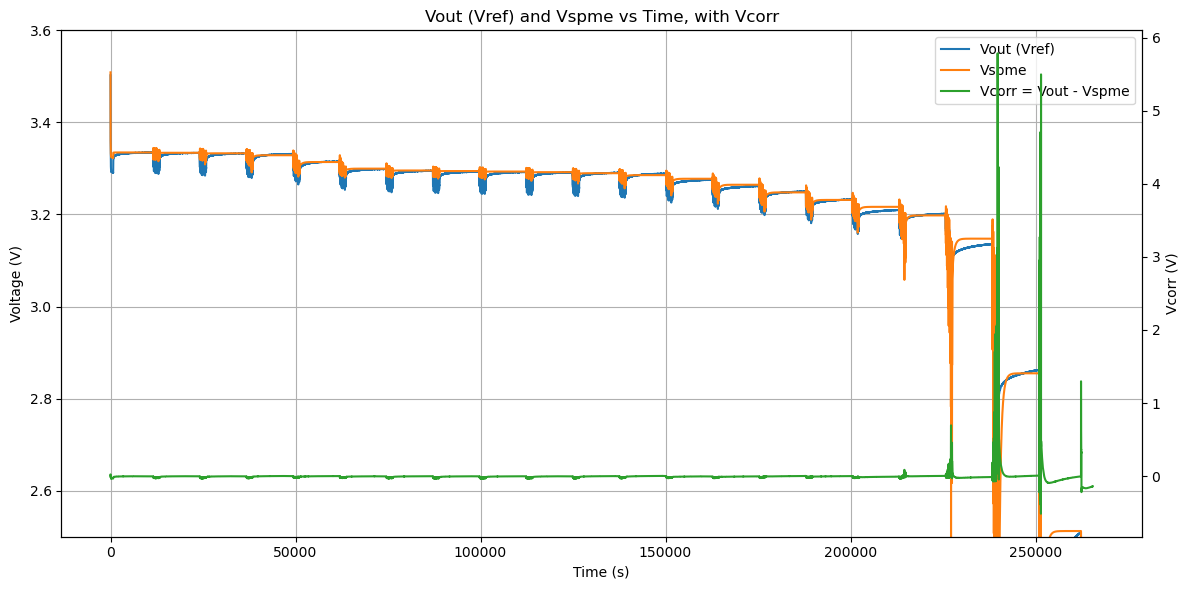

In [4]:
import matplotlib.pyplot as plt

df = extracted_data['udds2_1c_rest_25C_struct']

fig, ax1 = plt.subplots(figsize=(12,6))

# Left y-axis: Vout (Vref) and Vspme
ax1.plot(df['time'], df['Vref'], label='Vout (Vref)', color='C0')
ax1.plot(df['time'], df['Vspme'], label='Vspme', color='C1')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim([2.5, 3.6])
ax1.set_title('Vout (Vref) and Vspme vs Time, with Vcorr')
ax1.grid(True)

# Right y-axis: Vcorr = Vout - Vspme
ax2 = ax1.twinx()
Vcorr = df['Vref'] - df['Vspme']
ax2.plot(df['time'], Vcorr, label='Vcorr = Vout - Vspme', color='C2')
ax2.set_ylabel('Vcorr (V)')
# Optionally, you may want to set Vcorr y-limits, e.g.:
# ax2.set_ylim([Vcorr.min(), Vcorr.max()])

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.tight_layout()
plt.show()




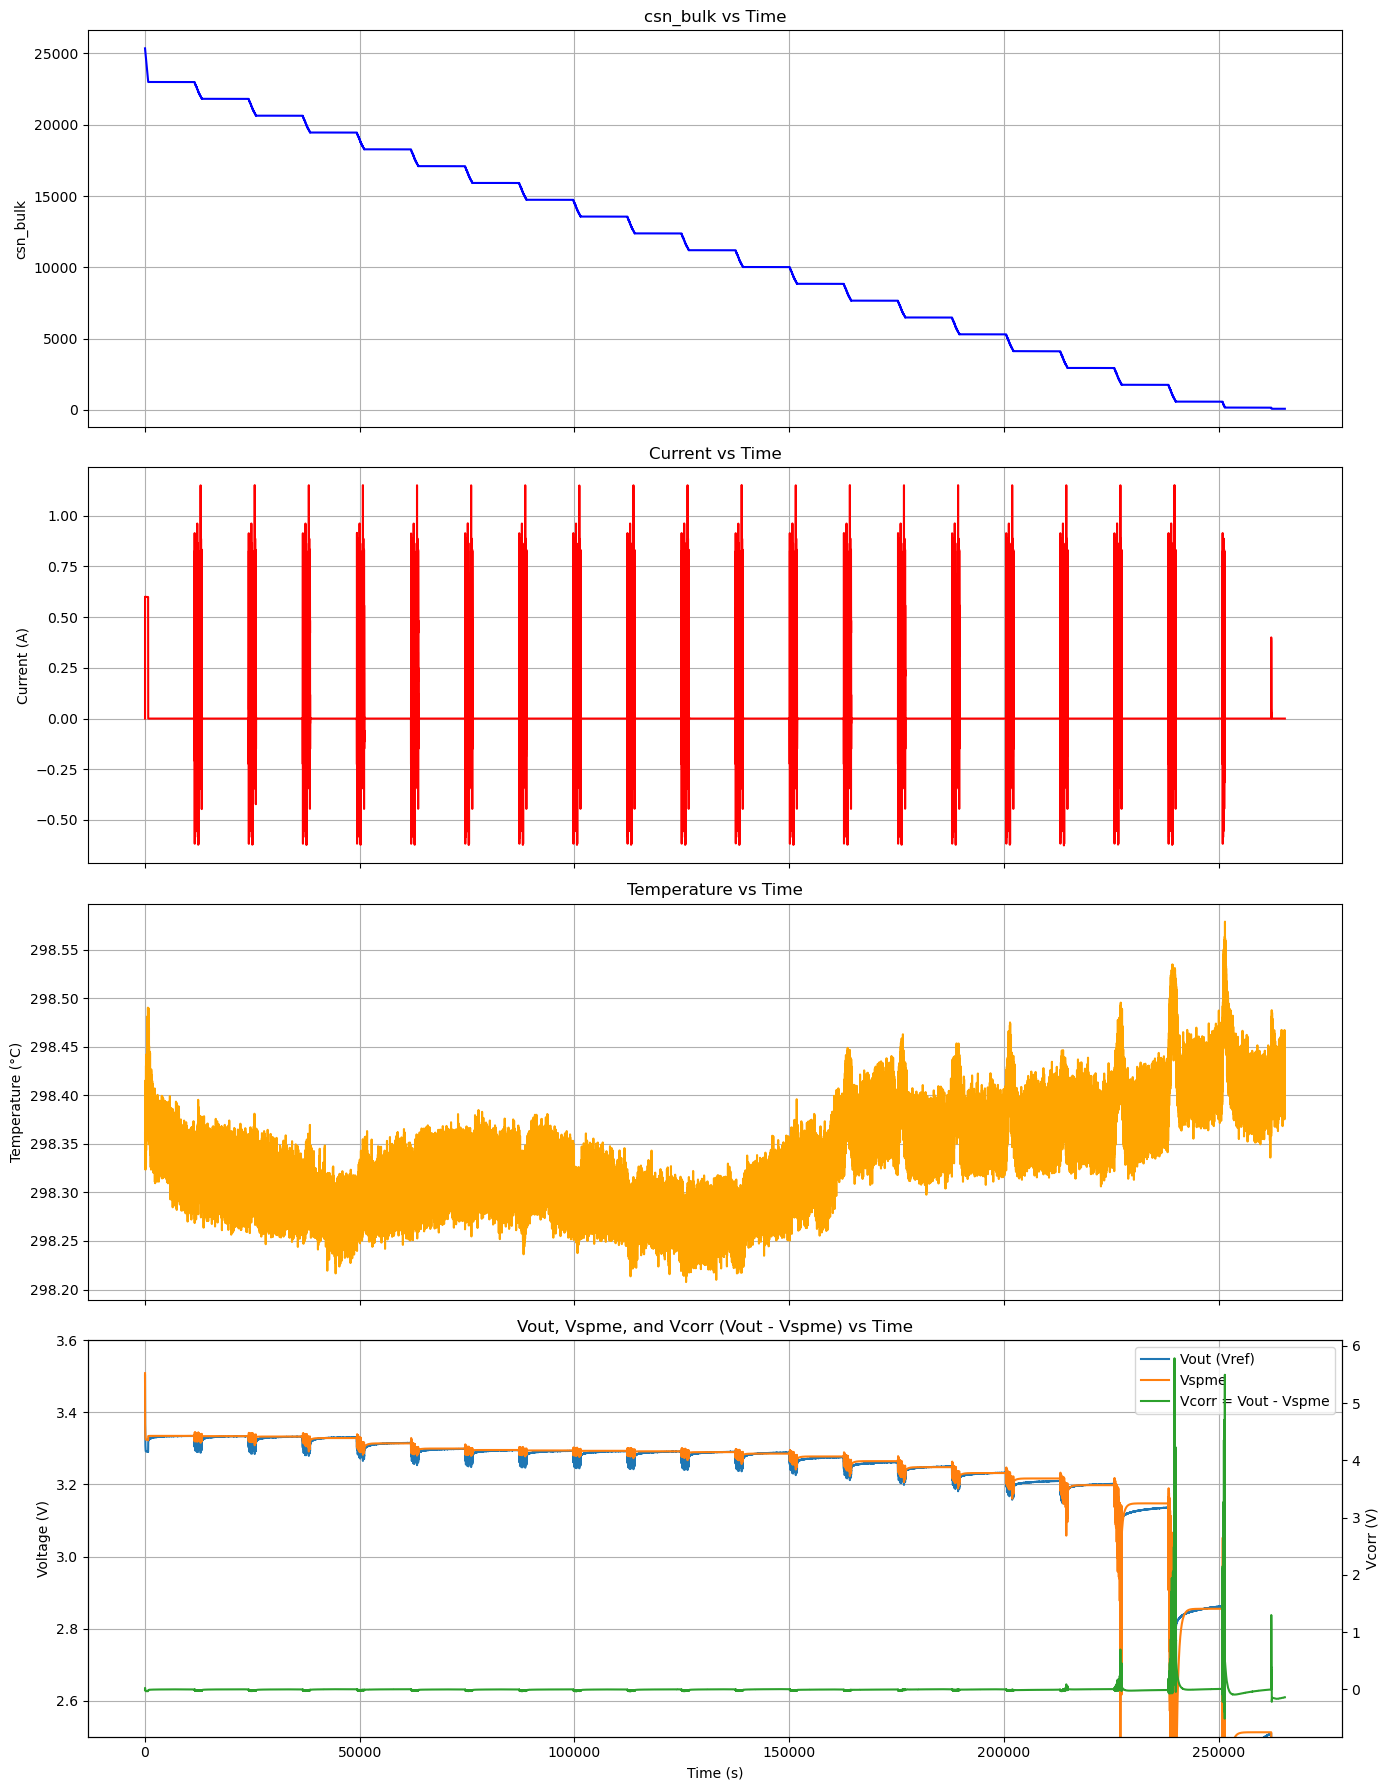

In [5]:
import matplotlib.pyplot as plt

# Assume df_sampled is already defined just as in the next cell (sampled first 10% of data)
df_vis = df

fig, axs = plt.subplots(4, 1, figsize=(14, 18), sharex=True)

# 1. csn_bulk
axs[0].plot(df_vis["time"], df_vis["c_s_n_bulk"], color="blue")
axs[0].set_ylabel("csn_bulk")
axs[0].set_title("csn_bulk vs Time")
axs[0].grid(True)

# 2. I (Current)
axs[1].plot(df_vis["time"], df_vis["current"], color="red")
axs[1].set_ylabel("Current (A)")
axs[1].set_title("Current vs Time")
axs[1].grid(True)

# 3. Temperature (T)
axs[2].plot(df_vis["time"], df_vis["temperature"], color="orange")
axs[2].set_ylabel("Temperature (°C)")
axs[2].set_title("Temperature vs Time")
axs[2].grid(True)

# 4. Vout, Vspme (left) and Vcorr (right)
ax4 = axs[3]
ax4.plot(df_vis["time"], df_vis["Vref"], label="Vout (Vref)", color="C0")
ax4.plot(df_vis["time"], df_vis["Vspme"], label="Vspme", color="C1")
ax4.set_ylabel("Voltage (V)")
ax4.set_title("Vout, Vspme, and Vcorr (Vout - Vspme) vs Time")
ax4.set_ylim([2.5, 3.6])  # Set voltage axis limits as requested
ax4.grid(True)

ax4r = ax4.twinx()
Vcorr = df_vis["Vref"] - df_vis["Vspme"]
ax4r.plot(df_vis["time"], Vcorr, label="Vcorr = Vout - Vspme", color="C2")
ax4r.set_ylabel("Vcorr (V)")

# Combine legends from both y-axes
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4r.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

axs[3].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()




==== [diff 기반 수동 중복 제거] ====
감지된 문제 인덱스: 0개

제거할 인덱스: []
원본 데이터: 10619개
제거 후 데이터: 10619개
제거된 데이터: 0개
✓ 모든 중복이 제거되었습니다!
✓ 시간이 strictly increasing입니다.

✓ 최종 선택: diff 기반 수동 제거 방법 사용
✓ 최종 데이터에서 모든 time이 strictly increasing입니다.

==== [데이터 업데이트] ====

==== [Downsampling] ====
원본 10619 → 다운샘플링 1015 points (9.6%)
-0.0029397657382364962
0.0022546092947479967
✓ 업데이트된 데이터:
  - 데이터 포인트 수: 1015
  - 시간 범위: 114136.83 - 124754.83 초
  - Vcorr 범위: -0.012 - -0.000 V
  - Y shape: (1015,)
  - Y mean: -0.003
  - Y std: 0.002


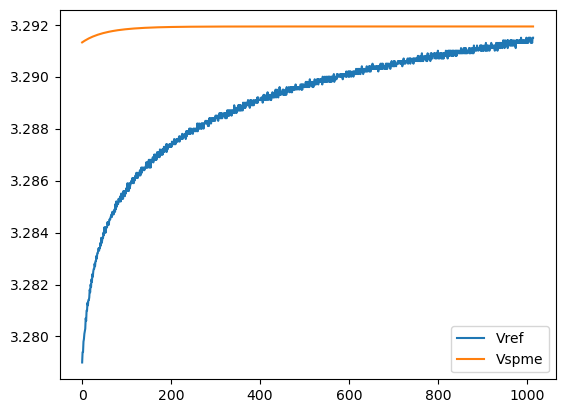

In [69]:
# Import the NEW clean implementation
from battery_ode_wrapper import train_battery_neural_ode



# Use 10-20% of data for validation
df = extracted_data['udds2_1c_rest_25C_struct']
# df = extracted_data['udds2_1c_norest_25C_struct']
total_length = len(df)
start_idx = int(0.43 * total_length)  # Rest
end_idx = int(0.47 * total_length)    # Rest
# start_idx = int(0.4 * total_length)  # pulse
# end_idx = int(0.45 * total_length)    # pulse
df_sampled = df.iloc[start_idx:end_idx].reset_index(drop=True)

df_sorted = df_sampled.sort_values('time').reset_index(drop=True)




# =============================
# ===== Remove Duplicates =====
# =============================
print("\n==== [diff 기반 수동 중복 제거] ====")

# 원본 데이터
df_original = df_sorted.copy()
time_float = df_original['time'].astype(np.float32).values
diff = np.diff(time_float)

# 문제 인덱스 찾기
problem_idx = np.where(diff <= 0)[0]
print(f"감지된 문제 인덱스: {len(problem_idx)}개")

# 각 문제를 분석하고 제거할 인덱스 결정
indices_to_remove = []
for idx in problem_idx:
    t0 = time_float[idx]
    t1 = time_float[idx+1]
    diff_val = t1 - t0
    
    if abs(diff_val) < 1e-10:  # 중복
        print(f"  중복 발견: idx={idx} (t={t0}) --> idx={idx+1} (t={t1})")
        indices_to_remove.append(idx + 1)  # 두 번째 인덱스 제거
    else:  # 내림차순
        print(f"  내림차순 발견: idx={idx} (t={t0}) --> idx={idx+1} (t={t1})")
        indices_to_remove.append(idx + 1)  # 두 번째 인덱스 제거

# 중복 제거
indices_to_remove = sorted(set(indices_to_remove))  # 중복 제거 및 정렬
print(f"\n제거할 인덱스: {indices_to_remove}")

# 실제 제거
df_clean_manual = df_original.drop(index=indices_to_remove).reset_index(drop=True)

print(f"원본 데이터: {len(df_original)}개")
print(f"제거 후 데이터: {len(df_clean_manual)}개")
print(f"제거된 데이터: {len(df_original) - len(df_clean_manual)}개")

# 검증
time_clean = df_clean_manual['time'].astype(np.float32).values
diff_clean = np.diff(time_clean)
problem_idx_clean = np.where(diff_clean <= 0)[0]

if len(problem_idx_clean) == 0:
    print("✓ 모든 중복이 제거되었습니다!")
    print("✓ 시간이 strictly increasing입니다.")
else:
    print(f"⚠ 아직 {len(problem_idx_clean)}개의 문제가 남아있습니다.")
    for idx in problem_idx_clean:
        t0 = time_clean[idx]
        t1 = time_clean[idx+1]
        diff_val = t1 - t0
        print(f"  idx={idx}: t={t0} --> idx={idx+1}: t={t1} (diff={diff_val:.8f})")

# 최종 데이터로 설정
df_clean = df_clean_manual
print(f"\n✓ 최종 선택: diff 기반 수동 제거 방법 사용")

# 최종 검증
time_clean = df_clean['time'].astype(np.float32).values
diff_clean = np.diff(time_clean)
problem_idx_clean = np.where(diff_clean <= 0)[0]

if len(problem_idx_clean) == 0:
    print("✓ 최종 데이터에서 모든 time이 strictly increasing입니다.")
else:
    print(f"⚠ 최종 데이터에서도 {len(problem_idx_clean)}개의 문제가 남아있습니다.")
    for idx in problem_idx_clean:
        t0 = time_clean[idx]
        t1 = time_clean[idx+1]
        diff_ = t1-t0
        print(f"  idx={idx}: t={t0} --> idx+1={idx+1}: t={t1} (diff={diff_:.8f})")

# 중복 제거된 데이터로 모든 변수 업데이트
print("\n==== [데이터 업데이트] ====")
df_sorted = df_clean  # 중복 제거된 데이터로 교체
# =============================
# ===== Remove Duplicates =====
# =============================





# ========================
# ===== Downsampling =====
# ========================
print("\n==== [Downsampling] ====")

downsample_interval = 10  # N초마다 sampling

time = df_sorted['time'].values
selected = [0]  # 첫 point

for i in range(len(time) - 1):
    if time[i] >= time[selected[-1]] + downsample_interval:
        selected.append(i)

if selected[-1] != len(time) - 1:
    selected.append(len(time) - 1)

df_sorted = df_sorted.iloc[selected].reset_index(drop=True)
print(f"원본 {len(time)} → 다운샘플링 {len(df_sorted)} points ({len(df_sorted)/len(time)*100:.1f}%)")
# ========================
# ===== Downsampling =====
# ========================





# =========================
# ======= Smoothing =======
# =========================
Y_raw = df_sorted['Vref'].values - df_sorted['Vspme'].values
Y = smooth_Vcorr(Y_raw, 100)


# Y = Y_raw
# =========================
# ======= Smoothing =======
# =========================



Ymean = Y.mean()
Ystd = Y.std()

Vspme_mean = df_sorted['Vspme'].mean()
Vspme_std = df_sorted['Vspme'].std()


# data_dict 업데이트
data_dict = {
    'time': df_sorted['time'].astype(np.float32),
    'csn_bulk': df_sorted['c_s_n_bulk'].astype(np.float32)/30555, # normalize by max csn_bulk
    'I': df_sorted['current'].astype(np.float32)/0.25, 
    'T': (df_sorted['temperature'].astype(np.float32) - 298.15) / 10,
    # 'X': X,
    'Y': (Y -Ymean) / Ystd,
    'Y_mean': Ymean,
    'Y_std': Ystd,
    'V_spme': ( df_sorted['Vspme'].astype(np.float32) - Vspme_mean) / Vspme_std,
    'V_spme_mean': Vspme_mean,
    'V_spme_std': Vspme_std,
    'V_meas': df_sorted['Vref'].astype(np.float32)
}

print(Ymean)
print(Ystd)

print(f"✓ 업데이트된 데이터:")
print(f"  - 데이터 포인트 수: {len(df_sorted)}")
print(f"  - 시간 범위: {df_sorted['time'].min():.2f} - {df_sorted['time'].max():.2f} 초")
print(f"  - Vcorr 범위: {Y.min():.3f} - {Y.max():.3f} V")
print(f"  - Y shape: {Y.shape}")
print(f"  - Y mean: {Ymean:.3f}")
print(f"  - Y std: {Ystd:.3f}")


df_sorted['current'].astype(np.float32).std()




plt.figure()
plt.plot(df_sorted['Vref'].values, label='Vref')
plt.plot(df_sorted['Vspme'].values, label='Vspme')
plt.legend()
plt.show()


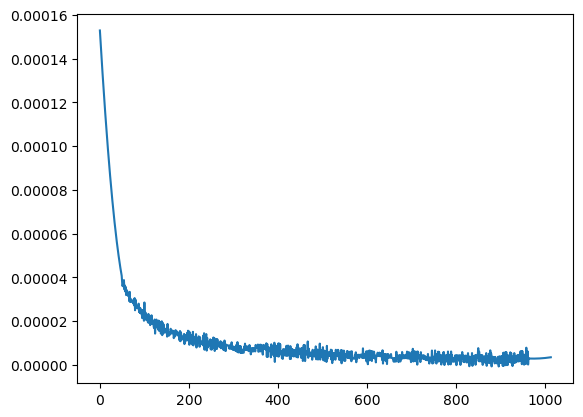

In [70]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Create subplots with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Raw Vcorr
fig.add_trace(
    go.Scatter(
        x=data_dict["time"],
        y=Y_raw,
        mode='lines',
        name='Vcorr_raw',
        line=dict(color='red', width=1),
        opacity=0.7
    ),
    secondary_y=False
)

# Smooth Vcorr
fig.add_trace(
    go.Scatter(
        x=data_dict["time"],
        y=Y,
        mode='lines',
        name='Vcorr_smooth',
        line=dict(color='blue', width=2),
        opacity=0.7
    ),
    secondary_y=False
)

# Current on secondary y-axis
fig.add_trace(
    go.Scatter(
        x=data_dict["time"],
        y=data_dict["I"] * 0.25,  # De-normalize if needed
        mode='lines',
        name='Current',
        line=dict(color='gray', width=1.5, dash='dash'),
        opacity=0.5
    ),
    secondary_y=True
)

# Update layout
fig.update_xaxes(title_text='Time (s)')
fig.update_yaxes(title_text='Vcorr (V)', secondary_y=False)
fig.update_yaxes(title_text='Current (A)', secondary_y=True)

fig.update_layout(
    title='Vcorr_smooth vs Vcorr_raw with Current',
    hovermode='x unified',
    width=1000,
    height=500
)

fig.show()


# ===== Diff plot with current =====
fig2 = make_subplots(specs=[[{"secondary_y": True}]])

# dVcorr/dt
time_diff = data_dict["time"][1:]  # time for diff
fig2.add_trace(
    go.Scatter(
        x=time_diff,
        y=np.diff(Y),
        mode='lines',
        name='dVcorr/dt',
        line=dict(color='blue', width=1),
    ),
    secondary_y=False
)

# Current on secondary y-axis
fig2.add_trace(
    go.Scatter(
        x=data_dict["time"],
        y=data_dict["I"] * 0.25,  # De-normalize if needed
        mode='lines',
        name='Current',
        line=dict(color='gray', width=1.5, dash='dash'),
        opacity=0.5
    ),
    secondary_y=True
)

# Update layout
fig2.update_xaxes(title_text='Time (s)')
fig2.update_yaxes(title_text='dVcorr/dt (V/s)', secondary_y=False)
fig2.update_yaxes(title_text='Current (A)', secondary_y=True)

fig2.update_layout(
    title='dVcorr/dt with Current',
    hovermode='x unified',
    width=1000,
    height=500
)

fig2.show()




plt.figure()
plt.plot(np.diff(Y))

In [71]:
print(data_dict["csn_bulk"].mean())  
print(data_dict["I"][data_dict["I"]>0].mean())  
print(data_dict["I"][data_dict["I"]<0].mean())
print(data_dict["T"].mean())  

print(data_dict["V_spme"])

print(f"Vspme raw range: {df_sorted['Vspme'].min():.3f} ~ {df_sorted['Vspme'].max():.3f}")
print(f"Vspme mean: {df_sorted['Vspme'].mean():.6f}")
print(f"Vspme std: {df_sorted['Vspme'].std():.6f}")

print(f"Vcorr raw range: {Y.min():.3f} ~ {Y.max():.3f}")
print(f"Vcorr mean: {Ymean:.6f}")
print(f"Vcorr std: {Ystd:.6f}")

0.4051846
nan
nan
0.012936567
0      -6.082863
1      -5.957546
2      -5.837242
3      -5.719445
4      -5.606660
          ...   
1010    0.358405
1011    0.358405
1012    0.358405
1013    0.358405
1014    0.358405
Name: Vspme, Length: 1015, dtype: float32
Vspme raw range: 3.291 ~ 3.292
Vspme mean: 3.291898
Vspme std: 0.000095
Vcorr raw range: -0.012 ~ -0.000
Vcorr mean: -0.002940
Vcorr std: 0.002255


In [72]:
# # Load pretrained model
# import torch
# from battery_ode_wrapper import BatteryODEWrapper

# device = 'cuda'  # or 'cpu'

# # Checkpoint 형식인지 확인하고 적절히 로드
# saved_data = torch.load("best_model_rmse0.64mV.pth", map_location=device)

# # Checkpoint 형식 (새 형식)인지 확인
# if isinstance(saved_data, dict) and 'model_state_dict' in saved_data:
#     # Checkpoint 형식: model_state_dict 추출
#     saved_state = saved_data['model_state_dict']
#     training_info = saved_data.get('training_info', {})
    
#     # 학습 정보 출력 (선택사항)
#     if training_info:
#         print(f"Previous training info:")
#         print(f"  - Best RMSE: {training_info.get('best_rmse', 'N/A'):.2f}mV")
#         print(f"  - Best epoch: {training_info.get('best_epoch', 'N/A')}")
#         print(f"  - alpha={training_info.get('alpha', 'N/A')}, "
#               f"beta={training_info.get('beta', 'N/A')}, "
#               f"gamma={training_info.get('gamma', 'N/A')}")
# else:
#     # Legacy 형식: 그냥 state_dict
#     saved_state = saved_data

# # 모델에 로드
# ode_wrapper_new.load_state_dict(saved_state)

In [73]:
# Call training function
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs = 1000  # Increased from 100 to 300
# lr = 5e-4  # Rest
lr = 5e-4  # Pulse


seed = 42 # 42 : Vcorr_k, csn_k, I_k, T_k,
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True


ode_wrapper, history = train_battery_neural_ode(data_dict, num_epochs=num_epochs, lr=lr, device=device, verbose=True)


Neural Network Architecture
Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): Tanh()
  (8): Linear(in_features=16, out_features=1, bias=True)
)

Training Settings
data_dict keys: dict_keys(['time', 'csn_bulk', 'I', 'T', 'Y', 'Y_mean', 'Y_std', 'V_spme', 'V_spme_mean', 'V_spme_std', 'V_meas'])
max epochs: 1000
initial lr: 0.0005
device: cuda
patience: 10
alpha: 1.00
beta: 0.00
gamma: 0.00
GPU: 20MB
grad_clip_max: 50
verbose: True
Starting battery Neural ODE training...
Data points: 1015
Vcorr range (normalized): -4.027 ~ 1.082
✅ Best RMSE: 905.17mV at Epoch 1
Epoch   1/1000 | Method: rk4    | LR: 5.00e-04 | RMSE: 905.17mV | loss_V: 161181.64 | loss_dVdt: 4.32e-03 | loss_tv: 6.81e-01 | Steps: 4056 | Grad Norm before: 16599282.1913 | Grad Norm after:

In [ ]:
# # Load pretrained model
# import torch
# from battery_ode_wrapper import BatteryODEWrapper


# # Call training function
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# num_epochs = 500  # Increased from 100 to 300
# lr = 5e-4  # continue training


# # 1. 먼저 모델 로드 (위에서 설명한 방법)
# saved_data = torch.load("best_model_rmse0.99mV.pth", map_location=device)
# saved_state = saved_data['model_state_dict'] if isinstance(saved_data, dict) and 'model_state_dict' in saved_data else saved_data

# ode_wrapper_new = BatteryODEWrapper(device).to(device)
# ode_wrapper_new.load_state_dict(saved_state)

# # 2. 모델을 파일로 다시 저장 (임시로)
# temp_model_path = "best_model_rmse0.99mV.pth"
# torch.save(saved_state, temp_model_path)  # state_dict만 저장

# # 3. train_battery_neural_ode 호출 (pretrained_model_path 사용)
# ode_wrapper, history = train_battery_neural_ode(
#     data_dict, 
#     num_epochs=num_epochs, 
#     lr=lr, 
#     device=device, 
#     verbose=True,
#     pretrained_model_path=temp_model_path  # ← 이렇게 사용
# )

C:\Users\ljw76\AppData\Local\Temp\ipykernel_65984\3402742679.py:14: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.




🔄 Loading pretrained model from: best_model_rmse0.99mV.pth
✅ Pretrained model loaded successfully! (legacy format)

Neural Network Architecture
Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): Tanh()
  (8): Linear(in_features=16, out_features=1, bias=True)
)

Training Settings
data_dict keys: dict_keys(['time', 'csn_bulk', 'I', 'T', 'Y', 'Y_mean', 'Y_std', 'V_spme', 'V_spme_mean', 'V_spme_std', 'V_meas'])
max epochs: 500
initial lr: 0.0005
device: cuda
patience: 10
alpha: 1.00
beta: 0.00
gamma: 0.00
GPU: 21MB
grad_clip_max: 50
verbose: True
Starting battery Neural ODE training...
Data points: 1834
Vcorr range (normalized): -2.872 ~ 1.452


KeyboardInterrupt: 

In [74]:
# 트레이닝 후
from battery_ode_wrapper import simulate_battery_ode
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')  # Reset backend

Vcorr_pred, Vcorr_target, Vtotal_pred, Vtotal_meas, time = simulate_battery_ode(
    ode_wrapper, data_dict, device=device, plot=True
)


Simulation Results:
Vcorr RMSE: 0.64 mV
Vtotal RMSE: 0.64 mV

